In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import category_encoders as ce

In [21]:
df = pd.read_csv("../data/processed/NY_SLI_INSTL_YEARS_ADJUSTED.csv", low_memory=False)
#df.info()
#df.head()

In [22]:
updated_df = df.drop(['Lead Gooseneck, Pigtail or Connector Currently Present', 'Current Public Side SL Material', 'Was Public SL Material Ever Previously Lead', 'Public SL Material Verification Method', 'Customer SL Material', 'SL Category', 'Current SL Material Category', 'Public SL Size', 'Public SL Size Category'], axis=1)
updated_df.head()

,Service Line Locality,Street Address,Zip Code,State,Public SL Installation or Replacement Date,Customer SL Material Verification Method,Lead Solder Present,Building Type,POU or POE Treatment Present,Customer SL Installation or Replacement Date,...,Note,Location,Customer SL Material Category,Public SL Material Verification Method Category,Lead Connector Present Category,Current Public Side SL Material Category,Was Public SL Material Ever Previously Lead Category,Public SL Installation Year,Public SL Size Numeric,SL Category Cleaned
0,Cortland,40015-40020 Jefferson Rd.,13045,NY,1973,Records,Unknown,Multi Family,Unknown,1973.0,...,NaN,NaN,Copper,Records,no,Copper,no,1970.0,1.0,Non-Lead
1,Amenia,Lot 1,12592,NY,2023,Excavation,NaN,Single Family,NaN,2023.0,...,NaN,NaN,Plastic,Excavation,unknown,Plastic,no,1970.0,1.0,Non-Lead
2,Henderson,Vacant County 72,13650,NY,2003,NaN,NaN,NaN,NaN,2003.0,...,106.05-1-5.21,NaN,Other,Other,unknown,Other,unknown,1970.0,NaN,Unknown
3,Town of Cicero,6890 E TAFT RD,13057,NY,Unknown,Records,No,Single Family,Unknown,1989.0,...,PR103136,NaN,Copper,Records,no,Copper,no,NaN,1.0,Non-Lead
4,City of Syracuse,WILLIS AVE,13204,NY,Unknown,Records,Unknown,Business,Unknown,1930.0,...,PR111008,NaN,Galvanized,Field Inspection,no,Copper,no,NaN,1.0,Unknown


In [23]:
# ============================================================
# 1️⃣  IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# ============================================================
# 2️⃣  DEFINE TARGET AND FEATURES
# ============================================================
y = updated_df['SL Category Cleaned'].str.lower().apply(
    lambda x: 1 if 'lead' in str(x) and 'non' not in str(x) else 0
)

# Drop the target and obvious text columns
drop_cols = ['SL Category Cleaned', 'Street Address', 'Note', 'Location']
X = updated_df.drop(columns=drop_cols, errors='ignore')



In [24]:

# ============================================================
# 3️⃣  DROP HIGH-CARDINALITY CATEGORICAL COLUMNS
# ============================================================
high_card_cols = [
    col for col in X.select_dtypes(include=['object']).columns
    if X[col].nunique() > 100
]
print(f"Dropping high-cardinality columns: {high_card_cols}")
X = X.drop(columns=high_card_cols, errors='ignore')

# ============================================================
# 4️⃣  LABEL ENCODE REMAINING CATEGORICAL COLUMNS
# ============================================================
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# ============================================================
# 5️⃣  HANDLE MISSING VALUES (NA / NAN)
# ============================================================
# Fill numeric NaNs with median
X_encoded = X_encoded.fillna(X_encoded.median(numeric_only=True))

# Optional: print NaN summary before filling
nan_summary = X_encoded.isna().sum()
print("\nColumns with remaining NaNs after fill:\n", nan_summary[nan_summary > 0])


Dropping high-cardinality columns: ['Service Line Locality', 'Public SL Installation or Replacement Date']

Columns with remaining NaNs after fill:
 Series([], dtype: int64)


In [25]:

# ============================================================
# 6️⃣  SPLIT DATA
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

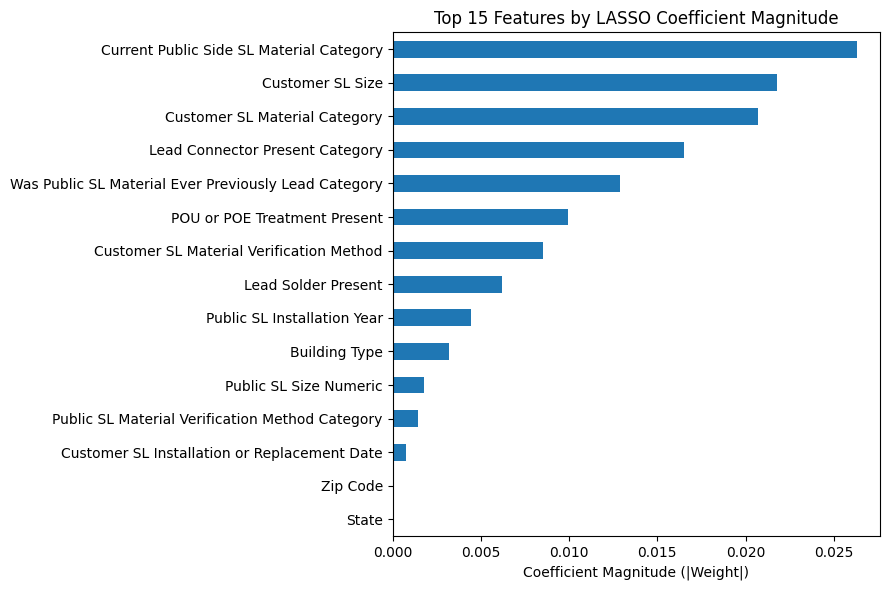


Top Predictive Features (Positive → More Likely Lead):
Zip Code                                                0.000084
Customer SL Installation or Replacement Date            0.000734
Building Type                                           0.003195
Lead Solder Present                                     0.006223
POU or POE Treatment Present                            0.009936
Was Public SL Material Ever Previously Lead Category    0.012903
Lead Connector Present Category                         0.016486
Customer SL Material Category                           0.020702
Customer SL Size                                        0.021799
Current Public Side SL Material Category                0.026303
dtype: float64

Top Predictive Features (Negative → More Likely Non-Lead):
Customer SL Material Verification Method          -0.008543
Public SL Installation Year                       -0.004426
Public SL Size Numeric                            -0.001771
Public SL Material Verification Method 

In [27]:

# ============================================================
# 8️⃣  FEATURE IMPORTANCE (COEFFICIENT MAGNITUDE)
# ============================================================
importance = pd.Series(model.coef_[0], index=X_encoded.columns)
importance = importance.sort_values()

# Top 15 features by absolute magnitude
top_features = importance.abs().sort_values(ascending=False).head(15)

# ============================================================
# 9️⃣  VISUALIZE TOP FEATURES
# ============================================================
plt.figure(figsize=(9, 6))
top_features.sort_values().plot(kind='barh')
plt.title("Top 15 Features by LASSO Coefficient Magnitude")
plt.xlabel("Coefficient Magnitude (|Weight|)")
plt.tight_layout()
plt.show()

# ============================================================
# 🔟  PRINT RESULTS
# ============================================================
print("\nTop Predictive Features (Positive → More Likely Lead):")
print(importance.tail(10))

print("\nTop Predictive Features (Negative → More Likely Non-Lead):")
print(importance.head(10))